### Импорты, форматы

In [819]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [8,5]
import gc
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import lightgbm as lgb

In [693]:
import os
PATH="../input/"
print(os.listdir(PATH))

['sample_submit_zero.csv', 'test_data.csv', 'train_answers.csv', 'train_data.csv']


In [694]:
train = pd.read_csv(PATH + 'train_data.csv',)
test = pd.read_csv(PATH + 'test_data.csv',)
train_answers = pd.read_csv(PATH + 'train_answers.csv',)
submission = pd.read_csv(PATH + 'sample_submit_zero.csv', header=None)
print ("формат обучающей выборки:", train.shape)
print ("формат тестовой выборки:", test.shape) 
print ("формат ответов по трейну:", train_answers.shape) 
print ("формат образца сабмишена:", submission.shape) 

формат обучающей выборки: (5337, 6)
формат тестовой выборки: (3615, 6)
формат ответов по трейну: (943, 5)
формат образца сабмишена: (630, 5)


#### Трейн

In [695]:
train.head(10)

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1164,6132,62,656,276,803
1,1399,6132,184,662,235,740
2,1694,6132,63,648,272,830
3,916,6132,111,637,253,831
4,1621,6132,60,651,242,819
5,1092,6132,39,649,249,825
6,301,31297,29,393,126,487
7,1508,31297,25,399,120,485
8,535,31297,25,399,108,472
9,254,18168,209,739,534,1051


#### Тест

In [696]:
test.head(10)

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1581,34804,86,640,242,743
1,1351,34804,85,655,273,766
2,161,34804,85,648,268,748
3,313,5704,32,618,647,1268
4,1097,5704,25,620,602,1242
5,1525,5704,118,690,583,1191
6,957,32082,50,437,259,575
7,947,32082,42,414,252,583
8,237,32082,63,424,250,569
9,191,32082,59,483,262,584


#### Ответы на тест - ground truth

In [697]:
train_answers.head()

,itemId,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,5,198,827,649,1340
1,10,26,605,433,847
2,13,233,698,622,920
3,30,61,368,329,530
4,32,30,536,328,813


#### Нулевой сабмишен

In [698]:
submission.head()

,0,1,2,3,4
0,18,0,0,0,0
1,19,0,0,0,0
2,33,0,0,0,0
3,62,0,0,0,0
4,114,0,0,0,0


#### исследование файлов

In [699]:
submission[0].nunique()

630

In [700]:
test.itemId.nunique()

630

**итого уникальных айтемов в сабмишене и в тесте - 630**

**Посмотрим распределение кол-ва оценок по каждому айтему**

**тест**

In [701]:
test_counts = test.groupby('itemId').count().userId

(array([  1., 220.,  17.,  64.,  99.,  61.,  56.,  57.,  31.,  17.,   6.,
          1.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 <a list of 12 Patch objects>)

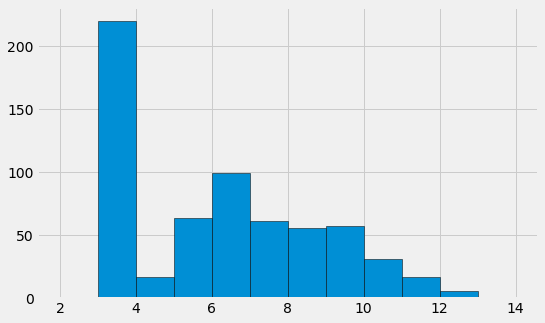

In [702]:
plt.hist(test_counts, edgecolor = 'k', bins = 12)

In [703]:
test_counts.value_counts()[:1]

3    220
Name: userId, dtype: int64

In [704]:
test_counts.value_counts()[1:].sum()

410

**Итого: 220 случаев 3х оценок, суммарно 410 всех  остальных оценок по тесту**

**трейн**

In [705]:
train_counts = train.groupby('itemId').count().userId
len(train_counts)

943

In [706]:
train_counts.max()

24

(array([358.,  23.,  92., 148.,  85.,  65.,  87.,  50.,  22.,   7.,   2.,
          0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <a list of 21 Patch objects>)

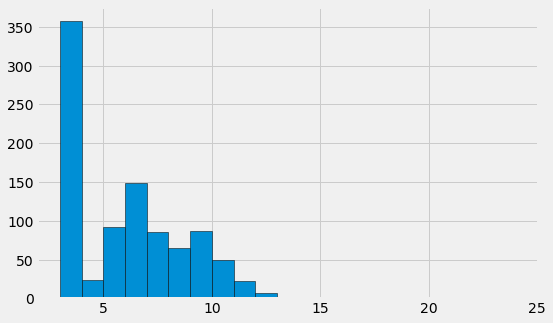

In [707]:
plt.hist(train_counts, edgecolor = 'k', bins = 21)

In [708]:
train_counts.value_counts()[:1]

3    358
Name: userId, dtype: int64

In [709]:
train_counts.value_counts()[1:].sum()

585

**Итого: 358 случаев 3х оценок, суммарно 585 всех  остальных оценок по трейну**

Создадим сабмишен с mean по каждому значению

In [710]:
submission_mean = test.groupby('itemId').mean()
submission_mean.drop('userId', axis=1, inplace=True)
submission_mean = submission_mean.astype(int)
submission_mean.insert(loc=0, column='ID', value = submission_mean.index)

In [711]:
submission_mean.head()

,ID,Xmin,Ymin,Xmax,Ymax
itemId,,,,,
18,18,135,704,729,1071
19,19,29,560,114,725
33,33,46,393,374,633
62,62,90,964,564,1167
114,114,63,575,207,767


In [712]:
submission_mean.to_csv('submission_mean.csv', index=False, header=False)

**результат посылки средних значений П: 0.5037841**

**сравним юзеров по тесту и трейну**

In [713]:
print("юзеров в трейне: ", train.userId.nunique())
print("юзеров в тесте: ", test.userId.nunique())

юзеров в трейне:  1357
юзеров в тесте:  1192


In [714]:
train_users = train.groupby('userId').count().index
test_users = test.groupby('userId').count().index

In [715]:
unique_users_test = []
unique_users_train = []

for i in test_users:
    if not (i in train_users):
        unique_users_test.append(i)
        
for i in train_users:
    if not (i in test_users):
        unique_users_train.append(i)
        
print("уникальных юзеров в тесте: ", len(unique_users_test))
print("уникальных юзеров в трейне: ",len(unique_users_train))   

уникальных юзеров в тесте:  191
уникальных юзеров в трейне:  356


**таким образом, юзеры теста и трейна пересекаются, но не совпадают.**

**попробуем очистить данные, устранив выбросы**

In [716]:
#функция считает среднее по оценкам, и исключает 

def mymean(data):
    
    # сюда будем писать результаты
    
    df_ans = data.max()

    for col in ['Xmin', 'Ymin', 'Xmax', 'Ymax']:
        # data[col] - pandas series, набор значений по координате. Задача - вычислить его mean без аутлаеров
        
        std = data[col].std()
        mean = data[col].mean()
        temp_col = []
        
        # пройдем по значениям столбца и если значение лежит меньше, чем в std*0.85 - то добавим его во временный столбец        
        
        for i in data[col]:
            if abs(mean - i) < std*0.8:
                temp_col.append(i)
                
        #если в столбец ниего вообще не попало - возьмем среднее как есть. Если там что-то есть - то возьмем то, что нашли
                
        if len(temp_col) > 0:
            ans = np.array(temp_col).mean()
        else:
            ans = data[col].mean()
                   
        
        # ans нужно в итоге присвоить то, что пойдет в таблицу
        #ans = data[col].mean()
        
        df_ans[col] = ans
        
    return df_ans

In [717]:
submission_mymean = test.groupby('itemId').apply(mymean)
submission_mymean.drop('userId', axis=1, inplace=True)
submission_mymean = submission_mymean.astype(int)
#submission_mymean.insert(loc=0, column='ID', value = submission_mymean.index)

In [718]:
submission_mymean.head(10)

,itemId,Xmin,Ymin,Xmax,Ymax
itemId,,,,,
18,18,135,704,729,1071
19,19,27,559,112,727
33,33,43,384,365,629
62,62,90,975,613,1166
114,114,69,575,210,760
146,146,72,481,559,816
156,156,87,802,155,879
163,163,30,322,212,461
164,164,5,149,349,649


In [719]:
submission_mymean.to_csv('submission0-8.csv', index=False, header=False)

**Решение с обрезкой по 0.8 (наилучшее) дает П: 0.5115125**

**Мимакс - возьмем минимальное Xmin Ymin и максимальное Xmax Ymax в тесте**

In [720]:
#функция берет минимальное и максимальное по разным столбцам 

def myminmax(data):
    
    # сюда будем писать результаты

    df_ans = data.max()
    
    # банально выберем минимумы и максимумы

    for col in ['Xmin', 'Ymin', 'Xmax', 'Ymax']:
        # data[col] - pandas series, набор значений по координате. Задача - вычислить его mean без аутлаеров
        
        if col == 'Xmin' or col == "Ymin":
            df_ans[col] = data[col].min()
            
        if col == 'Xmax' or col == "Ymax":
            df_ans[col] = data[col].max()

    return df_ans

In [721]:
submission_myminmax = test.groupby('itemId').apply(myminmax)
submission_myminmax.drop('userId', axis=1, inplace=True)
submission_myminmax = submission_myminmax.astype(int)

**посмотрим визуально, что получилось**

In [722]:
test.sort_values(by="itemId").head(10)

,userId,itemId,Xmin,Ymin,Xmax,Ymax
1230,903,18,126,774,694,1010
1231,1723,18,144,634,764,1132
523,903,19,28,559,113,721
522,141,19,34,564,119,729
521,1723,19,27,559,112,727
2034,366,33,21,380,414,652
2035,1565,33,43,388,365,629
2036,141,33,75,413,345,620
2890,1508,62,98,1054,553,1259
2893,141,62,125,980,623,1130


In [723]:
submission_myminmax.head(10)

,itemId,Xmin,Ymin,Xmax,Ymax
itemId,,,,,
18,18,126,634,764,1132
19,19,27,559,119,729
33,33,21,380,414,652
62,62,35,824,639,1262
114,114,41,570,216,780
146,146,17,211,643,1118
156,156,74,802,160,887
163,163,21,317,213,465
164,164,4,146,401,681


**вроде работает. Загрузим**

In [724]:
submission_myminmax.to_csv('submission_minmax_simple.csv', index=False, header=False)

**результат простого минмакса - П: 0.5678444** (и таких результатов довольно много)

**Напишем тот же минмакс, но с выкидыванием аутлаеров свыше 0,8std**

In [725]:
#функция берет минимальное и максимальное по разным столбцам, выкидываая аутлаеров 

def myminmax_filtered(data):
    
    # сюда будем писать результаты

    df_ans = data.max()
    
    # банально выберем минимумы и максимумы

    for col in ['Xmin', 'Ymin', 'Xmax', 'Ymax']:
        # data[col] - pandas series, набор значений по координате. Задача - вычислить его mean без аутлаеров
        
        std = data[col].std()
        mean = data[col].mean()
        temp_col = []
        
        # пройдем по значениям столбца и если значение лежит меньше, чем в std*0.85 - то добавим его во временный столбец        
        
        for i in data[col]:
            if abs(mean - i) < std*0.8:
                temp_col.append(i)
                
        # Если в итоге в темп ничего не залетело - возьмем как есть
        
        if len(temp_col) < 1:
        
            if col == 'Xmin' or col == "Ymin":
                df_ans[col] = data[col].min()

            if col == 'Xmax' or col == "Ymax":
                df_ans[col] = data[col].max()
                
        else:
            
            if col == 'Xmin' or col == "Ymin":
                df_ans[col] = min(temp_col)

            if col == 'Xmax' or col == "Ymax":
                df_ans[col] =  max(temp_col)

    return df_ans

In [726]:
submission_myminmax_filtered = test.groupby('itemId').apply(myminmax_filtered)
submission_myminmax_filtered.drop('userId', axis=1, inplace=True)
submission_myminmax_filtered = submission_myminmax_filtered.astype(int)

In [727]:
submission_myminmax_filtered.to_csv('submission_minmax_filtered_0-8.csv', index=False, header=False)

**результат П: 0.5270054 - снижение**

**вычислим по трейну юзеров, которые ошибаются сильнее всего**

In [728]:
train_merged = pd.merge(train, train_answers, how='inner', on = 'itemId')

In [729]:
train_merged.head(10)

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,1164,6132,62,656,276,803,47,650,213,812
1,1399,6132,184,662,235,740,47,650,213,812
2,1694,6132,63,648,272,830,47,650,213,812
3,916,6132,111,637,253,831,47,650,213,812
4,1621,6132,60,651,242,819,47,650,213,812
5,1092,6132,39,649,249,825,47,650,213,812
6,301,31297,29,393,126,487,18,390,122,472
7,1508,31297,25,399,120,485,18,390,122,472
8,535,31297,25,399,108,472,18,390,122,472
9,254,18168,209,739,534,1051,35,713,656,1082


In [730]:
train_merged["mse"] = ((train_merged.Xmin - train_merged.Xmin_true)**2 + (train_merged.Xmax - train_merged.Xmax_true)**2\
                       + (train_merged.Ymin - train_merged.Ymin_true)**2 + (train_merged.Ymax - train_merged.Ymax_true)**2)/4

In [731]:
train_merged.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true,mse
0,1164,6132,62,656,276,803,47,650,213,812,1077.75
1,1399,6132,184,662,235,740,47,650,213,812,6145.25
2,1694,6132,63,648,272,830,47,650,213,812,1016.25
3,916,6132,111,637,253,831,47,650,213,812,1556.50
4,1621,6132,60,651,242,819,47,650,213,812,265.00


**юзеры трейна, отранжированные по фейлам**

In [732]:
user_fails = train_merged.groupby('userId').mean().mse.sort_values(ascending=False)
user_fails.head(20)

userId
1019    217615.750000
671     202095.000000
388     174108.625000
344     147222.250000
533     127838.750000
1615    126893.500000
569     121956.750000
333     118177.500000
688     109075.250000
1002    103343.750000
915      98982.625000
417      83625.375000
921      81811.833333
862      78676.750000
1494     78217.250000
797      77012.250000
1546     72952.083333
719      72224.750000
1364     71290.750000
305      70077.125000
Name: mse, dtype: float64

In [733]:
user_fails.index

Int64Index([1019,  671,  388,  344,  533, 1615,  569,  333,  688, 1002,
            ...
             361,  718,  758, 1050,  693,   35, 1230,   41, 1539,   77],
           dtype='int64', name='userId', length=1357)

**sanity check - то же самое, но без квадрата, по модулю**

In [734]:
train_merged2 = pd.merge(train, train_answers, how='inner', on = 'itemId')
train_merged2["mse"] = (abs(train_merged.Xmin - train_merged.Xmin_true) + abs(train_merged.Xmax - train_merged.Xmax_true)\
                       + abs(train_merged.Ymin - train_merged.Ymin_true) + abs(train_merged.Ymax - train_merged.Ymax_true))/4
user_fails2 = train_merged2.groupby('userId').mean().mse.sort_values(ascending=False)
sum(user_fails2.index == user_fails.index)

26

**удалим из теста 10 самых фейлящих юзеров**

In [735]:
test.shape

(3615, 6)

In [736]:
test_nofails10 = test[~test["userId"].isin(user_fails.index[0:10])]

test_nofails10.shape

(3605, 6)

In [737]:
submission_nofails = test.groupby('itemId').apply(myminmax)
submission_nofails.drop('userId', axis=1, inplace=True)
submission_nofails = submission_nofails.astype(int)
submission_nofails.to_csv('submission_nofails10.csv', index=False, header=False)

In [738]:
def save_nofails(threshold, test=test, user_fails=user_fails):
    test_nofails = test[~test["userId"].isin(user_fails.index[0:threshold])]
    submission_nofails = test_nofails.groupby('itemId').apply(myminmax)
    submission_nofails.drop('userId', axis=1, inplace=True)
    submission_nofails = submission_nofails.astype(int)
    submission_nofails.to_csv('submission_nofails' + str(threshold) + '.csv', index=False, header=False)
    print(threshold, test_nofails.shape)

In [739]:
for i in [10, 100]:
    save_nofails(i)

10 (3605, 6)
100 (3467, 6)


- 10 - П: 0.5678450 !!!
- 20 - П: 0.5678450 !!
- 30 - П: 0.5677362
- 40 - П: 0.5677362
- 50 - П: 0.5678378

In [740]:
for i in [4, 5, 6, 9]:
    save_nofails(i)

4 (3610, 6)
5 (3608, 6)
6 (3607, 6)
9 (3606, 6)


**Предположение - юзеры не дотягивают рамку вправо. Вычтем 1 пиксель из Ymax**

In [741]:
submission_nofails.Ymax -= 1

In [742]:
submission_nofails.to_csv('submission_nofails10_minus1.csv', index=False, header=False)

итог - ухудшение рещультата

**Провалидируемся на трейн выборке. Для этого надо определить функцию iou**

In [743]:
def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])


def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [744]:
train_merged["iou"] = train_merged[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [745]:
train_merged.iou.mean()

0.4528736712170044

- объединить тест и трейн по образцу Алисы
- закодировать категориальные признаки
- придумать еще признаки
- прогнать лгбм

**Слияние теста и трейна, запомнить индексы**

In [746]:
# Объединение датафреймов
full = pd.concat([train, test])

# Запомним индекс для разделения датасета
idx_split = train.shape[0]

In [747]:
full.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1164,6132,62,656,276,803
1,1399,6132,184,662,235,740
2,1694,6132,63,648,272,830
3,916,6132,111,637,253,831
4,1621,6132,60,651,242,819


**заполнение объединенного датафрейма с фичами - full_features**

добавим фичи 
- средние значения Y Y X X по разметке юзеров
- средние значения по моему расчету в пределах 0,8 стд
- периметр
- периметр минмакс
- средняя mse юзера
- количество сабмитов, совершенное данным юзером всего
- количество сабмитов по данному айтему
- юзеры как категориальные фичи

**приделаем минмакс как фичи**

In [748]:
full_features = full.copy()
#Sanity check
sum(full_features.index - full.index)

0

In [749]:
df_myminmax = full.groupby('itemId').apply(myminmax)
df_myminmax.drop("userId", axis=1, inplace=True)
df_myminmax.columns = ['itemId', 'Xmin_mm', 'Ymin_mm', 'Xmax_mm', 'Ymax_mm']
df_myminmax.drop("itemId", axis=1, inplace=True)

In [750]:
df_myminmax.head()

,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm
itemId,,,,
5,151,914,511,1331
10,72,559,427,858
13,46,600,621,981
18,126,634,764,1132
19,27,559,119,729


In [751]:
full_features = pd.merge(full, df_myminmax, how='left', left_on= 'itemId', right_index=True, sort=False)

In [752]:
#Sanity check
sum(full_features.index - full.index)

0

In [753]:
full_features.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm
0,1164,6132,62,656,276,803,39,637,276,831
1,1399,6132,184,662,235,740,39,637,276,831
2,1694,6132,63,648,272,830,39,637,276,831
3,916,6132,111,637,253,831,39,637,276,831
4,1621,6132,60,651,242,819,39,637,276,831


In [754]:
del(df_myminmax)
gc.collect()

74874

**простой mean**

In [755]:
df_mean = full.groupby('itemId').mean()
df_mean.drop("userId", axis=1, inplace=True)
df_mean.columns

Index(['Xmin', 'Ymin', 'Xmax', 'Ymax'], dtype='object')

In [756]:
df_mean.columns = ['Xmin_mean', 'Ymin_mean', 'Xmax_mean', 'Ymax_mean']

In [757]:
df_mean.head()

,Xmin_mean,Ymin_mean,Xmax_mean,Ymax_mean
itemId,,,,
5,184.333333,918.666667,501.333333,1248.666667
10,87.666667,562.666667,416.333333,855.333333
13,69.666667,603.000000,596.666667,966.666667
18,135.000000,704.000000,729.000000,1071.000000
19,29.666667,560.666667,114.666667,725.666667


In [758]:
full_features = pd.merge(full_features, df_mean, how='left', left_on= 'itemId', right_index=True, sort=False)
#Sanity check
sum(full_features.index - full.index)

0

In [759]:
full_features.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm,Xmin_mean,Ymin_mean,Xmax_mean,Ymax_mean
0,1164,6132,62,656,276,803,39,637,276,831,86.5,650.5,254.5,808.0
1,1399,6132,184,662,235,740,39,637,276,831,86.5,650.5,254.5,808.0
2,1694,6132,63,648,272,830,39,637,276,831,86.5,650.5,254.5,808.0
3,916,6132,111,637,253,831,39,637,276,831,86.5,650.5,254.5,808.0
4,1621,6132,60,651,242,819,39,637,276,831,86.5,650.5,254.5,808.0


In [760]:
del(df_mean)
gc.collect()

14

**Средние значения по моему расчету в пределах 0,8стд**

In [761]:
df_mymean = full.groupby('itemId').apply(mymean)
df_mymean.drop(["userId", "itemId"], axis=1, inplace=True)
df_mymean.columns

Index(['Xmin', 'Ymin', 'Xmax', 'Ymax'], dtype='object')

In [762]:
df_mymean.columns = ['Xmin_mymean', 'Ymin_mymean', 'Xmax_mymean', 'Ymax_mymean']

In [763]:
df_mymean.head()

,Xmin_mymean,Ymin_mymean,Xmax_mymean,Ymax_mymean
itemId,,,,
5,192,917,510,1255
10,95,559,420,856
13,69,603,614,969
18,135,704,729,1071
19,27,559,112,727


In [764]:
full_features = pd.merge(full_features, df_mymean, how='left', left_on= 'itemId', right_index=True, sort=False)
#Sanity check
print("Sanity check: ", sum(full_features.index - full.index))
full_features.head()

Sanity check:  0


,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm,Xmin_mean,Ymin_mean,Xmax_mean,Ymax_mean,Xmin_mymean,Ymin_mymean,Xmax_mymean,Ymax_mymean
0,1164,6132,62,656,276,803,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821
1,1399,6132,184,662,235,740,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821
2,1694,6132,63,648,272,830,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821
3,916,6132,111,637,253,831,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821
4,1621,6132,60,651,242,819,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821


In [765]:
del(df_mymean)
gc.collect()

37

**Периметр**

In [766]:
full_features["perimeter"] = (full_features["Xmax"] - full_features["Xmin"] + full_features["Ymax"] - full_features["Ymin"])*2
full_features["perimeter_mm"] = (full_features["Xmax_mm"] - full_features["Xmin_mm"] + full_features["Ymax_mm"] - full_features["Ymin_mm"])*2

In [767]:
print("Sanity check: ", sum(full_features.index - full.index))
full_features.head()

Sanity check:  0


,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm,Xmin_mean,Ymin_mean,Xmax_mean,Ymax_mean,Xmin_mymean,Ymin_mymean,Xmax_mymean,Ymax_mymean,perimeter,perimeter_mm
0,1164,6132,62,656,276,803,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821,722,862
1,1399,6132,184,662,235,740,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821,258,862
2,1694,6132,63,648,272,830,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821,782,862
3,916,6132,111,637,253,831,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821,672,862
4,1621,6132,60,651,242,819,39,637,276,831,86.5,650.5,254.5,808.0,74,651,248,821,700,862


**--статистики по юзерам--**

**Средняя mse юзера**

ранее мы посчитали среднюю ошибку юзера по трейну. Однако у нас нет ошибок по 191 юзеру из теста. Присвоим им среднюю из общих mse

In [768]:
user_fails.head()

userId
1019    217615.750
671     202095.000
388     174108.625
344     147222.250
533     127838.750
Name: mse, dtype: float64

всего у нас уникальных юзеров

In [769]:
len(unique_users_test)

191

In [770]:
unique_users_test[:10]

[1, 18, 19, 38, 47, 67, 82, 83, 84, 85]

сделаем новый Series с индексами как уникальные юзеры и значениями - mean всех ошибок

In [771]:
additional_users = pd.Series([user_fails.mean()]*len(unique_users_test), index = unique_users_test)
user_fails = train_merged.groupby('userId').mean().mse.sort_values(ascending=False)
user_fails = user_fails.append(additional_users)

sanity check

In [772]:
user_fails.shape

(1548,)

In [773]:
full_features["userId"].nunique()

1548

In [774]:
df_user_fails = user_fails.to_frame()
df_user_fails.columns = ["user_mse"]

In [775]:
full_features = pd.merge(full_features, df_user_fails, how='left', left_on= 'userId', right_index=True, sort=False)
#Sanity check
print("Sanity check: ", sum(full_features.index - full.index))
full_features.head()

Sanity check:  0


,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm,...,Ymin_mean,Xmax_mean,Ymax_mean,Xmin_mymean,Ymin_mymean,Xmax_mymean,Ymax_mymean,perimeter,perimeter_mm,user_mse
0,1164,6132,62,656,276,803,39,637,276,831,...,650.5,254.5,808.0,74,651,248,821,722,862,20532.916667
1,1399,6132,184,662,235,740,39,637,276,831,...,650.5,254.5,808.0,74,651,248,821,258,862,5515.333333
2,1694,6132,63,648,272,830,39,637,276,831,...,650.5,254.5,808.0,74,651,248,821,782,862,3210.875000
3,916,6132,111,637,253,831,39,637,276,831,...,650.5,254.5,808.0,74,651,248,821,672,862,9491.250000
4,1621,6132,60,651,242,819,39,637,276,831,...,650.5,254.5,808.0,74,651,248,821,700,862,21763.150000


Кол-во оценок, совершенное данным юзером

In [776]:
df_user_activity = full.groupby("userId").count().itemId.to_frame()
df_user_activity.columns = ["user_activity"]
print(df_user_activity.shape)
df_user_activity.head()

(1548, 1)


,user_activity
userId,
0,3
1,1
2,4
3,20
5,1


In [777]:
full_features = pd.merge(full_features, df_user_activity, how='left', left_on= 'userId', right_index=True, sort=False)
#Sanity check
print("Sanity check: ", sum(full_features.index - full.index))
full_features.head()

Sanity check:  0


,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm,...,Xmax_mean,Ymax_mean,Xmin_mymean,Ymin_mymean,Xmax_mymean,Ymax_mymean,perimeter,perimeter_mm,user_mse,user_activity
0,1164,6132,62,656,276,803,39,637,276,831,...,254.5,808.0,74,651,248,821,722,862,20532.916667,3
1,1399,6132,184,662,235,740,39,637,276,831,...,254.5,808.0,74,651,248,821,258,862,5515.333333,7
2,1694,6132,63,648,272,830,39,637,276,831,...,254.5,808.0,74,651,248,821,782,862,3210.875000,13
3,916,6132,111,637,253,831,39,637,276,831,...,254.5,808.0,74,651,248,821,672,862,9491.250000,10
4,1621,6132,60,651,242,819,39,637,276,831,...,254.5,808.0,74,651,248,821,700,862,21763.150000,8


In [778]:
full_features.shape

(8952, 22)

**--статистика айтемов--**

**количество оценок по данному айтему**

In [779]:
df_item_checks = full.groupby("itemId").count().userId.to_frame()
df_item_checks.columns = ["item_checks"]
print(df_item_checks.shape)
df_item_checks.head()

(1573, 1)


,item_checks
itemId,
5,3
10,3
13,3
18,2
19,3


Sanity check

In [780]:
630+358+585

1573

In [781]:
full_features = pd.merge(full_features, df_item_checks, how='left', left_on='itemId', right_index=True, sort=False)
#Sanity check
print("Sanity check: ", sum(full_features.index - full.index))
full_features.head()

Sanity check:  0


,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm,...,Ymax_mean,Xmin_mymean,Ymin_mymean,Xmax_mymean,Ymax_mymean,perimeter,perimeter_mm,user_mse,user_activity,item_checks
0,1164,6132,62,656,276,803,39,637,276,831,...,808.0,74,651,248,821,722,862,20532.916667,3,6
1,1399,6132,184,662,235,740,39,637,276,831,...,808.0,74,651,248,821,258,862,5515.333333,7,6
2,1694,6132,63,648,272,830,39,637,276,831,...,808.0,74,651,248,821,782,862,3210.875000,13,6
3,916,6132,111,637,253,831,39,637,276,831,...,808.0,74,651,248,821,672,862,9491.250000,10,6
4,1621,6132,60,651,242,819,39,637,276,831,...,808.0,74,651,248,821,700,862,21763.150000,8,6


**объединенный датасет full_featutes и индекс разделения idx_split готовы. Время строить модели**

дропнем userId. Так как фичи извлечены (активность и ошибки), можно попробовать без него. Запишем в датасет full1

In [782]:
full1 = full_features.drop("userId", axis=1)

ответы содержит train_answers

In [783]:
train_answers.columns

Index(['itemId', 'Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], dtype='object')

In [784]:
# запомним отдельно для последующей итерации по ним

answers_columns = ['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true']

x_train = full_features[:idx_split]
x_test = full_features[idx_split:]

In [785]:
#Sanity check

print(sum(x_train.index - train.index))
print(sum(x_test.index - test.index))

0
0


теперь прикрутим ответы к x_train

In [786]:
x_train = pd.merge(x_train, train_answers, how='left', on='itemId', sort=False)
#Sanity check
print("Sanity check: ", sum(x_train.index - train.index))
x_train.head()

Sanity check:  0


,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm,...,Ymax_mymean,perimeter,perimeter_mm,user_mse,user_activity,item_checks,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,1164,6132,62,656,276,803,39,637,276,831,...,821,722,862,20532.916667,3,6,47,650,213,812
1,1399,6132,184,662,235,740,39,637,276,831,...,821,258,862,5515.333333,7,6,47,650,213,812
2,1694,6132,63,648,272,830,39,637,276,831,...,821,782,862,3210.875000,13,6,47,650,213,812
3,916,6132,111,637,253,831,39,637,276,831,...,821,672,862,9491.250000,10,6,47,650,213,812
4,1621,6132,60,651,242,819,39,637,276,831,...,821,700,862,21763.150000,8,6,47,650,213,812


проверим как работают предсказания

In [787]:
clf = LGBMRegressor()

y = x_train["Xmin_true"]
x = x_train.drop(answers_columns, axis=1)

clf.fit(x, y)

predictions = clf.predict(x_test)

In [788]:
def my_predict(x_train, x_test, x_label):

    clf = LGBMRegressor()

    y = x_train[x_label]
    x = x_train.drop(answers_columns, axis=1)

    clf.fit(x, y)

    predictions = clf.predict(x_test)
    
    return predictions

In [789]:
submission_ff = test.copy()

for label in answers_columns:
    print ("Предсказываем: ", i)
    
    predictions = my_predict(x_train, x_test, label)
    submission_ff[label] = predictions 
    

Предсказываем:  9
Предсказываем:  9
Предсказываем:  9
Предсказываем:  9


In [790]:
submission_ff.drop(["Xmin", "Ymin", "Xmax", "Ymax"], axis=1, inplace=True)
submission_ff.columns = ['userId', 'itemId', "Xmin", "Ymin", "Xmax", "Ymax"]

submission_ff_minmax = submission_ff.groupby('itemId').apply(myminmax)
submission_ff_minmax.drop('userId', axis=1, inplace=True)
submission_ff_minmax = submission_ff_minmax.astype(int)
submission_ff_minmax.to_csv('submission_ff_minmax.csv', index=False, header=False)

In [791]:
submission_ff_mean = submission_ff.groupby('itemId').mean()
submission_ff_mean.drop('userId', axis=1, inplace=True)
submission_ff_mean = submission_ff_mean.astype(int)
submission_ff_mean.to_csv('submission_ff_mean.csv', index=True, header=False)

- mean: 0.5273316
- minmax: П: 0.5281104

In [792]:
full.shape

(8952, 6)

In [793]:
full_features.shape

(8952, 23)

**Добавим фич - как в среднем ошибался юзер по каждой координате**

In [794]:
train_merged["Xmin_err"] = train_merged["Xmin_true"] - train_merged["Xmin"]
train_merged["Xmax_err"] = train_merged["Xmax_true"] - train_merged["Xmax"]
train_merged["Ymin_err"] = train_merged["Ymin_true"] - train_merged["Ymin"]
train_merged["Ymax_err"] = train_merged["Ymax_true"] - train_merged["Ymax"]

In [795]:
user_fails_spec = train_merged.groupby('userId').mean()
user_fails_spec.drop(['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'Xmin_true', 'Ymin_true',
       'Xmax_true', 'Ymax_true', 'mse', 'iou'], inplace=True, axis=1)
user_fails_spec.head()

,Xmin_err,Xmax_err,Ymin_err,Ymax_err
userId,,,,
0,119.500000,20.000000,12.000000,-23.000000
2,-37.250000,88.250000,-78.000000,-26.750000
3,29.285714,9.285714,8.357143,-5.714286
5,-44.000000,-27.000000,-5.000000,-71.000000
7,103.000000,66.500000,-5.000000,235.000000


добавим неучтенных юзеров, присвоив среднее по ошибкам

In [796]:
user_fails_spec_unique_users = pd.DataFrame(np.nan,unique_users_test,user_fails_spec.columns)
user_fails_spec = pd.concat([user_fails_spec, user_fails_spec_unique_users], axis=0, join="outer")
user_fails_spec.fillna(user_fails_spec.mean(axis=0), inplace=True)

In [798]:
user_fails_spec.shape

(1548, 4)

In [801]:
full_features = pd.merge(full_features, user_fails_spec, how='left', left_on= 'userId', right_index=True, sort=False)
#Sanity check
print("Sanity check: ", sum(full_features.index - full.index))
full_features.head()

Sanity check:  0


,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm,...,Ymax_mymean,perimeter,perimeter_mm,user_mse,user_activity,item_checks,Xmin_err,Xmax_err,Ymin_err,Ymax_err
0,1164,6132,62,656,276,803,39,637,276,831,...,821,722,862,20532.916667,3,6,-73.333333,29.666667,-80.000000,148.666667
1,1399,6132,184,662,235,740,39,637,276,831,...,821,258,862,5515.333333,7,6,-117.333333,-26.666667,-19.666667,27.666667
2,1694,6132,63,648,272,830,39,637,276,831,...,821,782,862,3210.875000,13,6,-54.333333,-42.166667,6.000000,-28.000000
3,916,6132,111,637,253,831,39,637,276,831,...,821,672,862,9491.250000,10,6,-66.571429,28.285714,-54.285714,78.714286
4,1621,6132,60,651,242,819,39,637,276,831,...,821,700,862,21763.150000,8,6,-63.600000,75.600000,-97.800000,136.000000


**и обучим модель еще раз на новых фичах**

In [803]:
answers_columns

['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true']

In [805]:
x_train = full_features[:idx_split]
x_test = full_features[idx_split:]

In [806]:
#Sanity check

print(sum(x_train.index - train.index))
print(sum(x_test.index - test.index))

0
0


In [807]:
x_train = pd.merge(x_train, train_answers, how='left', on='itemId', sort=False)
#Sanity check
print("Sanity check: ", sum(x_train.index - train.index))
x_train.head()

Sanity check:  0


,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_mm,Ymin_mm,Xmax_mm,Ymax_mm,...,user_activity,item_checks,Xmin_err,Xmax_err,Ymin_err,Ymax_err,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,1164,6132,62,656,276,803,39,637,276,831,...,3,6,-73.333333,29.666667,-80.000000,148.666667,47,650,213,812
1,1399,6132,184,662,235,740,39,637,276,831,...,7,6,-117.333333,-26.666667,-19.666667,27.666667,47,650,213,812
2,1694,6132,63,648,272,830,39,637,276,831,...,13,6,-54.333333,-42.166667,6.000000,-28.000000,47,650,213,812
3,916,6132,111,637,253,831,39,637,276,831,...,10,6,-66.571429,28.285714,-54.285714,78.714286,47,650,213,812
4,1621,6132,60,651,242,819,39,637,276,831,...,8,6,-63.600000,75.600000,-97.800000,136.000000,47,650,213,812


In [808]:
submission_ff = test.copy()

for label in answers_columns:
    print ("Предсказываем: ", label)
    
    predictions = my_predict(x_train, x_test, label)
    submission_ff[label] = predictions 
    
submission_ff.drop(["Xmin", "Ymin", "Xmax", "Ymax"], axis=1, inplace=True)
submission_ff.columns = ['userId', 'itemId', "Xmin", "Ymin", "Xmax", "Ymax"]

submission_ff_minmax = submission_ff.groupby('itemId').apply(myminmax)
submission_ff_minmax.drop('userId', axis=1, inplace=True)
submission_ff_minmax = submission_ff_minmax.astype(int)
submission_ff_minmax.to_csv('submission_ff_errors_minmax.csv', index=False, header=False) 

Предсказываем:  Xmin_true
Предсказываем:  Ymin_true
Предсказываем:  Xmax_true
Предсказываем:  Ymax_true


**вписать сюда что получилось**

**Пишем предиктор с кросс-валидацией**

In [830]:
param = {
   "objective" : "regression",
    "metric" : "rmse",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 300,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : 10,
    "verbosity" : 500,
    "random_state" : 1337,
}

In [833]:
def my_predict(x_train, x_test, x_label):

    clf = LGBMRegressor()

    y = x_train[x_label]
    x = x_train.drop(answers_columns, axis=1)

    clf.fit(x, y)

    predictions = clf.predict(x_test)
    
    return predictions


def my_predict_regression(train, test, target):

    result=np.zeros(test.shape[0])

    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1337) #5 / 5
    
    for counter,(train_index, valid_index) in enumerate(rskf.split(train, train[target]),1):
        print ("current folder: ", counter)

        #Train data
        t=train.iloc[train_index]
        
        trn_data = lgb.Dataset(t.drop(target,axis=1), label=t[target])

        #Validation data
        v=train.iloc[valid_index]
        val_data = lgb.Dataset(v.drop(target,axis=1), label=v[target])

        #Training
        model = lgb.train(param, trn_data, 1000000, valid_sets = [val_data], verbose_eval=2000, early_stopping_rounds = 3) #1000
        result += model.predict(test)

    return result/counter

In [832]:
submission_ff = test.copy()

for label in answers_columns:
    print ("Предсказываем: ", label)
    
    predictions = my_predict_regression(x_train, x_test, label)
    submission_ff[label] = predictions 
    
submission_ff.drop(["Xmin", "Ymin", "Xmax", "Ymax"], axis=1, inplace=True)
submission_ff.columns = ['userId', 'itemId', "Xmin", "Ymin", "Xmax", "Ymax"]

submission_ff_minmax = submission_ff.groupby('itemId').apply(myminmax)
submission_ff_minmax.drop('userId', axis=1, inplace=True)
submission_ff_minmax = submission_ff_minmax.astype(int)
submission_ff_minmax.to_csv('submission_ff_errors_trained3.csv', index=False, header=False) 

Предсказываем:  Xmin_true
current folder:  1
Training until validation scores don't improve for 3 rounds.


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Early stopping, best iteration is:
[568]	valid_0's rmse: 61.7792
current folder:  2
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[568]	valid_0's rmse: 61.2641
current folder:  3
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[667]	valid_0's rmse: 58.9611
current folder:  4
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[712]	valid_0's rmse: 57.8372
current folder:  5
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[291]	valid_0's rmse: 64.0957


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  6
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[607]	valid_0's rmse: 62.4183
current folder:  7
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[439]	valid_0's rmse: 62.7664
current folder:  8
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[607]	valid_0's rmse: 59.5179
current folder:  9
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[538]	valid_0's rmse: 60.2756
current folder:  10
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[568]	valid_0's rmse: 59.273
current folder:  11
Training until validation scores don't improve for 3 rounds.

D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)



Early stopping, best iteration is:
[756]	valid_0's rmse: 60.9792
current folder:  12
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[538]	valid_0's rmse: 60.8188
current folder:  13
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[400]	valid_0's rmse: 63.4643
current folder:  14
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[668]	valid_0's rmse: 58.2859
current folder:  15
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[464]	valid_0's rmse: 59.9465
current folder:  16
Training until validation scores don't improve for 3 rounds.


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Early stopping, best iteration is:
[538]	valid_0's rmse: 62.1391
current folder:  17
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[538]	valid_0's rmse: 61.4097
current folder:  18
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[790]	valid_0's rmse: 57.9572
current folder:  19
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[560]	valid_0's rmse: 60.9915
current folder:  20
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[439]	valid_0's rmse: 61.6274
current folder:  21
Training until validation scores don't improve for 3 rounds.


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Early stopping, best iteration is:
[667]	valid_0's rmse: 62.363
current folder:  22
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[538]	valid_0's rmse: 60.0676
current folder:  23
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[400]	valid_0's rmse: 62.8697
current folder:  24
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[538]	valid_0's rmse: 60.9766
current folder:  25
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[511]	valid_0's rmse: 59.4486
Предсказываем:  Ymin_true


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  1
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[506]	valid_0's rmse: 89.9663
current folder:  2
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 79.8424
current folder:  3
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 82.907
current folder:  4
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 84.1767
current folder:  5
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[506]	valid_0's rmse: 88.5968


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  6
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 83.3474
current folder:  7
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[506]	valid_0's rmse: 87.699
current folder:  8
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 85.0591
current folder:  9
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[601]	valid_0's rmse: 79.6268
current folder:  10
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[496]	valid_0's rmse: 87.1854


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  11
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 81.3965
current folder:  12
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 82.6711
current folder:  13
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[506]	valid_0's rmse: 87.4649
current folder:  14
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[601]	valid_0's rmse: 80.9607
current folder:  15
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[506]	valid_0's rmse: 88.2165


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  16
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[744]	valid_0's rmse: 68.6559
current folder:  17
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[673]	valid_0's rmse: 74.7817
current folder:  18
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[673]	valid_0's rmse: 73.3876
current folder:  19
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 81.4128
current folder:  20
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 77.6331


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  21
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 82.1302
current folder:  22
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 83.1793
current folder:  23
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[506]	valid_0's rmse: 90.1698
current folder:  24
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 80.2809
current folder:  25
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 77.8805
Предсказываем:  Xmax_true


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  1
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 97.4435
current folder:  2
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 96.0524
current folder:  3
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 96.6874
current folder:  4
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[609]	valid_0's rmse: 93.0364
current folder:  5
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[825]	valid_0's rmse: 83.1212


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  6
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 95.5614
current folder:  7
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 93.2681
current folder:  8
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[538]	valid_0's rmse: 96.0405
current folder:  9
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 95.9032
current folder:  10
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[673]	valid_0's rmse: 85.9516


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  11
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[511]	valid_0's rmse: 98.6571
current folder:  12
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[580]	valid_0's rmse: 93.1339
current folder:  13
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 95.8742
current folder:  14
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 94.3776
current folder:  15
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[580]	valid_0's rmse: 92.9665


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  16
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 91.7294
current folder:  17
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 99.2447
current folder:  18
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 98.1809
current folder:  19
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[791]	valid_0's rmse: 81.0485
current folder:  20
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[601]	valid_0's rmse: 92.0389


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  21
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 98.2585
current folder:  22
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[580]	valid_0's rmse: 93.8528
current folder:  23
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[600]	valid_0's rmse: 92.1467
current folder:  24
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[580]	valid_0's rmse: 92.4653
current folder:  25
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[580]	valid_0's rmse: 91.808
Предсказываем:  Ymax_true


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  1
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 100.004
current folder:  2
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 99.0554
current folder:  3
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 95.3355
current folder:  4
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 98.3532
current folder:  5
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[610]	valid_0's rmse: 94.8807


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  6
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[609]	valid_0's rmse: 91.4731
current folder:  7
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 101.359
current folder:  8
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 98.8412
current folder:  9
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[610]	valid_0's rmse: 95.7764
current folder:  10
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 98.9904


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  11
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 95.1356
current folder:  12
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 102.639
current folder:  13
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 99.6044
current folder:  14
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[744]	valid_0's rmse: 85.8058
current folder:  15
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 94.6636


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  16
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 97.0408
current folder:  17
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[668]	valid_0's rmse: 89.2633
current folder:  18
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 100.922
current folder:  19
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[480]	valid_0's rmse: 106.299
current folder:  20
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 97.8473


D:\python\Anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


current folder:  21
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[567]	valid_0's rmse: 95.6993
current folder:  22
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[673]	valid_0's rmse: 90.8902
current folder:  23
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[668]	valid_0's rmse: 88.0294
current folder:  24
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[744]	valid_0's rmse: 87.9981
current folder:  25
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[674]	valid_0's rmse: 88.6988


поменять my_predict на что-то с кросс-валидацией

Как провалидироваться на трейне?

подобрать фичи и по гридсерчу - параметры дереьвев